In [ ]:
# Draft code for making a 1D contrast curve for my Altair data, for R>lambda/D

# Created 2019 Nov. 25 by E.S.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d

%matplotlib qt

In [2]:
def radial_data(data,annulus_width=1,working_mask=None,x=None,y=None,rmax=None):
    """
    From https://people.ucsc.edu/~ianc/python/_modules/radial_data.html
    
    r = radial_data(data,annulus_width,working_mask,x,y)
    
    A function to reduce an image to a radial cross-section.
    
    :INPUT:
      data   - whatever data you are radially averaging.  Data is
              binned into a series of annuli of width 'annulus_width'
              pixels.

      annulus_width - width of each annulus.  Default is 1.

      working_mask - array of same size as 'data', with zeros at
                        whichever 'data' points you don't want included
                        in the radial data computations.

      x,y - coordinate system in which the data exists (used to set
               the center of the data).  By default, these are set to
               integer meshgrids

      rmax -- maximum radial value over which to compute statistics
    
    :OUTPUT:
        r - a data structure containing the following
                   statistics, computed across each annulus:

          .r      - the radial coordinate used (outer edge of annulus)

          .mean   - mean of the data in the annulus

          .sum    - the sum of all enclosed values at the given radius

          .std    - standard deviation of the data in the annulus

          .median - median value in the annulus

          .max    - maximum value in the annulus

          .min    - minimum value in the annulus

          .numel  - number of elements in the annulus

    :EXAMPLE:        
      ::
        
        import numpy as np
        import pylab as py
        import radial_data as rad

        # Create coordinate grid
        npix = 50.
        x = np.arange(npix) - npix/2.
        xx, yy = np.meshgrid(x, x)
        r = np.sqrt(xx**2 + yy**2)
        fake_psf = np.exp(-(r/5.)**2)
        noise = 0.1 * np.random.normal(0, 1, r.size).reshape(r.shape)
        simulation = fake_psf + noise

        rad_stats = rad.radial_data(simulation, x=xx, y=yy)

        py.figure()
        py.plot(rad_stats.r, rad_stats.mean / rad_stats.std)
        py.xlabel('Radial coordinate')
        py.ylabel('Signal to Noise')
    """
    
# 2012-02-25 20:40 IJMC: Empty bins now have numel=0, not nan.
# 2012-02-04 17:41 IJMC: Added "SUM" flag
# 2010-11-19 16:36 IJC: Updated documentation for Sphinx
# 2010-03-10 19:22 IJC: Ported to python from Matlab
# 2005/12/19 Added 'working_region' option (IJC)
# 2005/12/15 Switched order of outputs (IJC)
# 2005/12/12 IJC: Removed decifact, changed name, wrote comments.
# 2005/11/04 by Ian Crossfield at the Jet Propulsion Laboratory
 
    import numpy as ny

    class radialDat:
        """Empty object container.
        """
        def __init__(self): 
            self.mean = None
            self.std = None
            self.median = None
            self.numel = None
            self.max = None
            self.min = None
            self.r = None

    #---------------------
    # Set up input parameters
    #---------------------
    data = ny.array(data)
    
    if working_mask==None:
        working_mask = ny.ones(data.shape,bool)
    
    npix, npiy = data.shape
    
    '''
    REMOVED 2020 MAR 15 --E.S.
    if x==None or y==None:
        x1 = ny.arange(-npix/2.,npix/2.)
        y1 = ny.arange(-npiy/2.,npiy/2.)
        x,y = ny.meshgrid(y1,x1)
    '''

    r = abs(x+1j*y)

    if rmax==None:
        rmax = r[working_mask].max()

    #---------------------
    # Prepare the data container
    #---------------------
    dr = ny.abs([x[0,0] - x[0,1]]) * annulus_width
    radial = ny.arange(rmax/dr)*dr + dr/2.
    nrad = len(radial)
    radialdata = radialDat()
    radialdata.mean = ny.zeros(nrad)
    radialdata.sum = ny.zeros(nrad)
    radialdata.std = ny.zeros(nrad)
    radialdata.median = ny.zeros(nrad)
    radialdata.numel = ny.zeros(nrad, dtype=int)
    radialdata.max = ny.zeros(nrad)
    radialdata.min = ny.zeros(nrad)
    radialdata.r = radial
    
    #---------------------
    # Loop through the bins
    #---------------------
    for irad in range(nrad): #= 1:numel(radial)
        minrad = irad*dr
        maxrad = minrad + dr
        thisindex = (r>=minrad) * (r<maxrad) * working_mask
        #import pylab as py
        #pdb.set_trace()
        if not thisindex.ravel().any():
            radialdata.mean[irad] = ny.nan
            radialdata.sum[irad] = ny.nan
            radialdata.std[irad]  = ny.nan
            radialdata.median[irad] = ny.nan
            radialdata.numel[irad] = 0
            radialdata.max[irad] = ny.nan
            radialdata.min[irad] = ny.nan
        else:
            radialdata.mean[irad] = data[thisindex].mean()
            radialdata.sum[irad] = data[r<maxrad].sum()
            radialdata.std[irad]  = data[thisindex].std()
            radialdata.median[irad] = ny.median(data[thisindex])
            radialdata.numel[irad] = data[thisindex].size
            radialdata.max[irad] = data[thisindex].max()
            radialdata.min[irad] = data[thisindex].min()
    
    #---------------------
    # Return with data
    #---------------------
    
    return radialdata

In [3]:
# host star amplitude (from cube median; not convolved with a smoothing kernel)

ampl_host = 53738
fwhm_pix = 1.028*9.46 # 1.028*lambda/D

In [4]:
# read in ADI frame

#adi_frame, header = fits.getdata("data/adi_frame_0.0_0.1_1e-10_1e-10_20200313_adi_frame_using_all_frames.fits",
#                                 0,header=True)
adi_frame, header = fits.getdata("/Users/nyumbani/Downloads/sn_check_cube_adi_frame_0.0_1.561344_0.0_0.001.fits",
                                 0,header=True)
adi_frame = adi_frame[0,:,:]

In [5]:
# make pixels of abs values 1e-3 nans
adi_frame[np.abs(adi_frame)<1e-3] = np.nan

/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


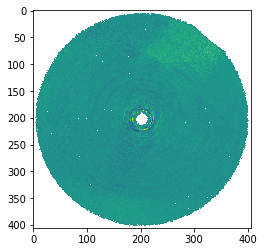

In [6]:
plt.imshow(adi_frame)
plt.show()

In [7]:
# make coordinate grid
# (note the need to set middle of image to zero)

x_range = np.arange(np.shape(adi_frame)[0]) - 0.5*np.shape(adi_frame)[0]
y_range = np.arange(np.shape(adi_frame)[1]) - 0.5*np.shape(adi_frame)[1]
xx, yy = np.meshgrid(x_range, y_range)

In [8]:
# calculate radial data

# width here is in pix
rad_stats_width01 = radial_data(adi_frame, annulus_width=1, x=xx, y=yy)

/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


In [9]:
# calculate radial data

#import radial_data as rad
rad_stats_width10 = radial_data(adi_frame, annulus_width=10, x=xx, y=yy)

/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


In [10]:
# calculate radial data

#import radial_data as rad
rad_stats_widthFWHM = radial_data(adi_frame, annulus_width=fwhm_pix, x=xx, y=yy)

/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


In [11]:
# calculate contrasts first
linear_5sig_contrast_width01 = np.divide(5.*rad_stats_width01.std,ampl_host)
linear_5sig_contrast_width10 = np.divide(5.*rad_stats_width10.std,ampl_host)
linear_5sig_contrast_widthFWHM = np.divide(5.*rad_stats_widthFWHM.std,ampl_host)

In [12]:
# convert linear contrast to del_mags
del_mags_contrast_width01 = -2.5*np.log10(linear_5sig_contrast_width01)
del_mags_contrast_width10 = -2.5*np.log10(linear_5sig_contrast_width10)
del_mags_contrast_widthFWHM = -2.5*np.log10(linear_5sig_contrast_widthFWHM)

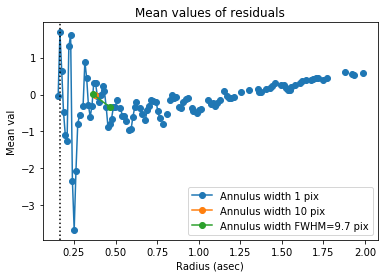

In [16]:
# plot means

plt.clf()
plt.plot(np.multiply(rad_stats_width01.r,0.0107), rad_stats_width01.mean, marker="o", label="Annulus width 1 pix")
plt.plot(np.multiply(rad_stats_width10.r,0.0107), rad_stats_width10.mean, marker="o", label="Annulus width 10 pix")
plt.plot(np.multiply(rad_stats_widthFWHM.r,0.0107), rad_stats_widthFWHM.mean, marker="o", label="Annulus width FWHM=9.7 pix")
plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
plt.legend()
plt.title("Mean values of residuals")
plt.xlabel("Radius (asec)")
plt.ylabel("Mean val")
plt.show()
#plt.savefig("junk.pdf")

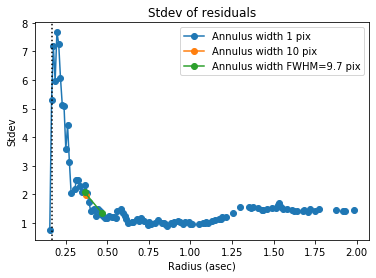

In [17]:
# plot stdev

plt.clf()
plt.plot(np.multiply(rad_stats_width01.r,0.0107), rad_stats_width01.std, marker="o", label="Annulus width 1 pix")
plt.plot(np.multiply(rad_stats_width10.r,0.0107), rad_stats_width10.std, marker="o", label="Annulus width 10 pix")
plt.plot(np.multiply(rad_stats_widthFWHM.r,0.0107), rad_stats_widthFWHM.std, marker="o", label="Annulus width FWHM=9.7 pix")
plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
plt.legend()
plt.title("Stdev of residuals")
plt.xlabel("Radius (asec)")
plt.ylabel("Stdev")
plt.show()
#plt.savefig("junk.pdf")

In [14]:
# interpolate values 

fwhm_pix = 9.728
fwhm_asec = np.multiply(fwhm_pix,0.0107)
fwhm_asec_array = fwhm_asec*np.arange(1,20)
#five_sig_guess = np.interp(fwhm_asec_array, np.multiply(rad_stats_width01.r,0.0107), linear_5sig_contrast_width01)

f = interp1d(x=np.multiply(rad_stats_widthFWHM.r,0.0107), y=linear_5sig_contrast_widthFWHM, kind='nearest')

In [34]:
# plot 5*stdev/ampl_host (linear)

plt.clf()
plt.plot(np.multiply(rad_stats_width01.r,0.0107), linear_5sig_contrast_width01, marker="o", label="Annulus width 1 pix")
plt.plot(np.multiply(rad_stats_width10.r,0.0107), linear_5sig_contrast_width10, marker="o", label="Annulus width 10 pix")
plt.plot(np.multiply(rad_stats_widthFWHM.r,0.0107), linear_5sig_contrast_widthFWHM, marker="o", label="Annulus width FWHM=9.7 pix")
#plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
[plt.axvline(x=i, linestyle=":", color="k") for i in fwhm_asec_array]
[plt.annotate(str(int(np.divide(i,fwhm_asec))), 
              xy=(i,0.0002), 
              xytext=(i,0.0002), 
              xycoords="data") for i in fwhm_asec_array]
#[plt.text(0.5, 0.5, 'text 0', props, rotation=0)]
plt.legend()
plt.title("Classical contrast curve (linear)")
plt.xlabel("Radius (asec)")
plt.ylabel("5*noise/ampl_host")
plt.show()
#plt.savefig("junk.pdf")

In [65]:
fwhm_asec_array

array([0.1040896, 0.2081792, 0.3122688, 0.4163584, 0.520448 , 0.6245376,
       0.7286272, 0.8327168, 0.9368064, 1.040896 , 1.1449856, 1.2490752,
       1.3531648, 1.4572544, 1.561344 , 1.6654336, 1.7695232, 1.8736128,
       1.9777024])

In [62]:
plt.plot(fwhm_asec_array,f(fwhm_asec_array))
plt.show()

In [60]:
len(linear_5sig_contrast_width01)

288

In [57]:
rad_stats_widthFWHM.r

array([  4.86244,  14.58732,  24.3122 ,  34.03708,  43.76196,  53.48684,
        63.21172,  72.9366 ,  82.66148,  92.38636, 102.11124, 111.83612,
       121.561  , 131.28588, 141.01076, 150.73564, 160.46052, 170.1854 ,
       179.91028, 189.63516, 199.36004, 209.08492, 218.8098 , 228.53468,
       238.25956, 247.98444, 257.70932, 267.4342 , 277.15908, 286.88396])

In [53]:
np.isfinite(linear_5sig_contrast_width01)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True,  True, False,  True, False,  True,
       False,  True,  True,  True, False,  True, False, False, False,
        True, False, False, False,  True, False, False, False, False,
        True,  True,

In [47]:
f(fwhm_asec_array)

array([       nan,        nan, 0.00019324, 0.00012616,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan])

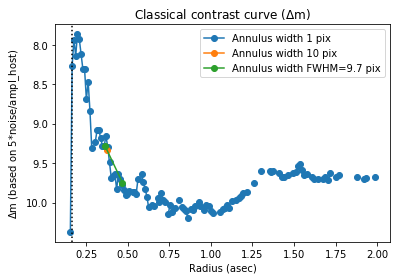

In [19]:
# plot 5*stdev/ampl_host (del_mag)

plt.clf()
plt.plot(np.multiply(rad_stats_width01.r,0.0107), del_mags_contrast_width01, marker="o", label="Annulus width 1 pix")
plt.plot(np.multiply(rad_stats_width10.r,0.0107), del_mags_contrast_width10, marker="o", label="Annulus width 10 pix")
plt.plot(np.multiply(rad_stats_widthFWHM.r,0.0107), del_mags_contrast_widthFWHM, marker="o", label="Annulus width FWHM=9.7 pix")
plt.axvline(x=np.multiply(15.5,0.0107), linestyle=":", color="k")
plt.legend()
plt.title("Classical contrast curve ($\Delta$m)")
plt.xlabel("Radius (asec)")
plt.ylabel("$\Delta$m (based on 5*noise/ampl_host)")
plt.gca().invert_yaxis()
plt.show()
#plt.savefig("junk.pdf")

In [13]:
# write out contrast curve to csv

contrast_data_df = pd.DataFrame(data=del_mags_contrast_widthFWHM, index=None, columns=["del_mag_widthFWHM"])
contrast_data_df["radius_pix"] = rad_stats_widthFWHM.r
contrast_data_df["asec"] = np.multiply(rad_stats_widthFWHM.r,0.0107)
#contrast_data_df["AU"] = np.multiply(contrast_data_df["asec"],5.13)
contrast_data_df["contrast_lim"] = linear_5sig_contrast_widthFWHM

contrast_data_df.to_csv("junk.csv")